In [1]:
import os
import uuid
import datetime
import pandas as pd
import numpy as np


dir = r'../../data'


def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        if "ok" in os.path.basename(root):
            for name in files:
                filepath = root + os.sep + name
                if filepath.endswith(".csv") and "2020" in filepath:
                    r.append(os.path.join(root, name))
                #end if
            #end for
    #end for
    return sorted(r)
#end list_files

def process_logs(df_name, weeks_to_keep, truncate_to_week):
    df = pd.read_csv(df_name, sep=",")
    df["date"] = pd.to_datetime(df['Hora'].str.zfill(16), dayfirst=True) #format='%d/%m/%y %H:%M')
    #df["date"] = df['date'] - pd.to_timedelta(df['date'].dt.dayofweek, unit='d') if truncate_to_week else df["date"]
    #eliminate hours, minutes and seconds
    df["date"] = df["date"].dt.date

    df["key"] = df["Nome completo"]
    #print("Unique users found: {}".format(df.key.nunique()))

    df["date"] = pd.to_datetime(df['date'])
    #get first date and add the offset
    thre = df.date.min() + datetime.timedelta(weeks = weeks_to_keep)
    #filter out weeks out of range
    df = df[(df['date'] < thre)]

    df['Inicio curso'] = df.date.min()
    df['Semana'] = ( (df.date - df.date.min()).dt.days // 7 ) + 1

    df = df[["date", "key", "Componente", "Nome do evento", "Semana", "Inicio curso"]]

    return df
#end process_logs

def process_grades(df_name):
    df = pd.read_csv(df_name, sep=",")
    df["key"] = df["Nome"] + " (" + df["Matrícula"].astype(str) + ")"
    df["target"] = df["Total do curso (Real)"].replace("-", 0.0).astype(float)
    df["target_cat"] = np.where(df['target'] >= 6.0 , 0, 1)
    return df[["key", "target", "target_cat"]]
#end process_grades

def process_dfs(df_list, weeks_to_keep=10, truncate_to_week=False):
    to_concat = []
    for i in range(0, len(df_list), 2):
        log_first = True if "logs" in df_list[i] else False
        turma = df_list[i].split(os.sep)[3]
        if log_first:
            df_logs = process_logs(df_list[i], weeks_to_keep, truncate_to_week)
            df_grades = process_grades(df_list[i+1])
        else:
            df_grades = process_grades(df_list[i])
            df_logs = process_logs(df_list[i+1], weeks_to_keep, truncate_to_week)
        #end if
        data_cols = df_logs.columns.tolist()
        data_cols.remove("key")
        print("Logs size = {}".format(len(df_logs)))
        print("Grades size = {}".format(len(df_grades)))
        final_df = df_logs.merge(df_grades, on="key", how="inner")

        final_df["group"] = turma

        final_df.loc[:, "id_group"] = 1
        final_df.loc[:, "id_subject"] = 1

        #anonymize groups and subjects
        final_df.loc[:, "id_group"] = final_df.groupby("group").id_group.transform(lambda g: str(uuid.uuid4()))
        final_df.loc[:, "id_subject"] = final_df.groupby("key").id_subject.transform(lambda g: str(uuid.uuid4()))

        to_keep = ["id_group", "id_subject", "key"] + data_cols + ["target", "target_cat"]
        to_concat.append( final_df[to_keep] )
    #end for
    return pd.concat(to_concat)
#end anonymize_dfs


In [2]:
df_list = list_files(dir)
df_final = process_dfs(df_list, weeks_to_keep=16)

Logs size = 29
Grades size = 33
Logs size = 58
Grades size = 24
Logs size = 18964
Grades size = 21


In [3]:
df_final.head()

,id_group,id_subject,key,date,Componente,Nome do evento,Semana,Inicio curso,target,target_cat
0,fbf93672-9d95-409b-a1ed-9c9c21bc0982,983eadc9-2625-4298-bb82-4634aaaa764a,Leticia Nazario da Silva (19204093),2021-08-02,Sistema,Curso visto,16,2021-04-14,9.5,0
1,fbf93672-9d95-409b-a1ed-9c9c21bc0982,983eadc9-2625-4298-bb82-4634aaaa764a,Leticia Nazario da Silva (19204093),2021-07-05,Sistema,Curso visto,12,2021-04-14,9.5,0
2,fbf93672-9d95-409b-a1ed-9c9c21bc0982,983eadc9-2625-4298-bb82-4634aaaa764a,Leticia Nazario da Silva (19204093),2021-07-05,Sistema,Curso visto,12,2021-04-14,9.5,0
3,fbf93672-9d95-409b-a1ed-9c9c21bc0982,5809fa50-3175-40ec-959e-f86ce0687814,Douglas Ribeiro da Rosa (20102025),2021-07-02,Sistema,Curso visto,12,2021-04-14,9.0,0
4,fbf93672-9d95-409b-a1ed-9c9c21bc0982,5809fa50-3175-40ec-959e-f86ce0687814,Douglas Ribeiro da Rosa (20102025),2021-07-02,Sistema,Lista de usuários vistos,12,2021-04-14,9.0,0


In [4]:
df_final.id_subject.nunique()

36

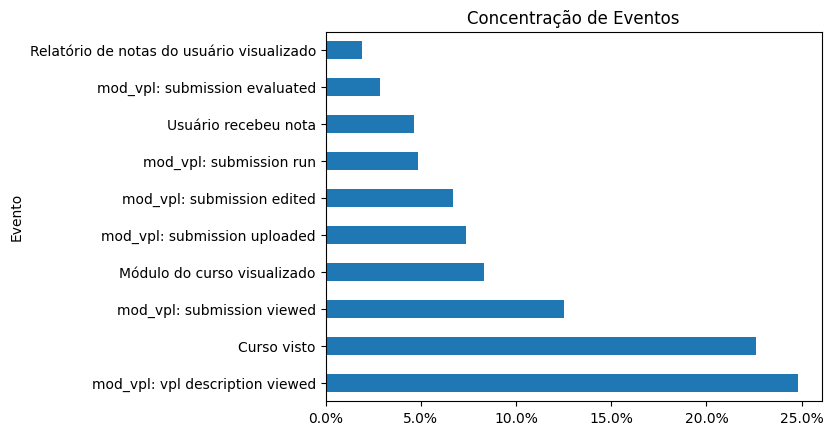

In [5]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

tmp = df_final["Nome do evento"].value_counts(normalize=True).rename_axis('Evento').reset_index(name='counts_norm') #.plot(kind="barh")
tmp = tmp[ tmp.counts_norm >= 0.01] #Only events accounting for 1% or more
tmp["Percentage"] = tmp.counts_norm * 100
ax = tmp.plot(x="Evento", y="Percentage",kind="barh", legend=None)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Concentração de Eventos")
plt.show()

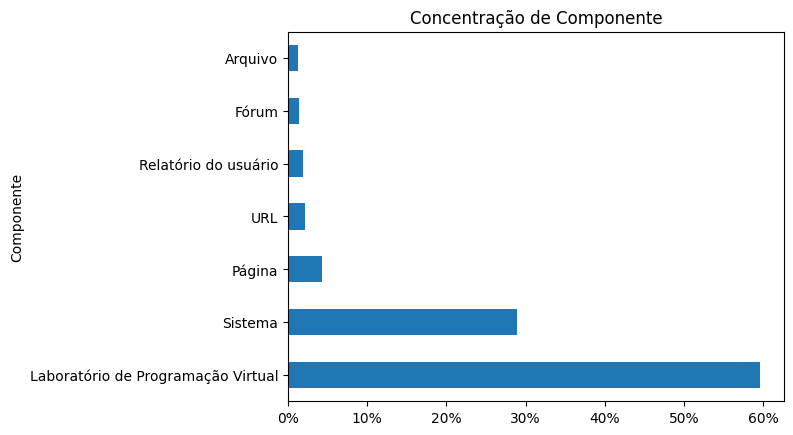

In [6]:
tmp = df_final["Componente"].value_counts(normalize=True).rename_axis('Componente').reset_index(name='counts_norm') #.plot(kind="barh")
tmp = tmp[ tmp.counts_norm >= 0.01]
tmp["Percentage"] = tmp.counts_norm * 100
ax = tmp.plot(x="Componente", y="Percentage",kind="barh", legend=None)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Concentração de Componente")
plt.show()

/home/eduardo/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


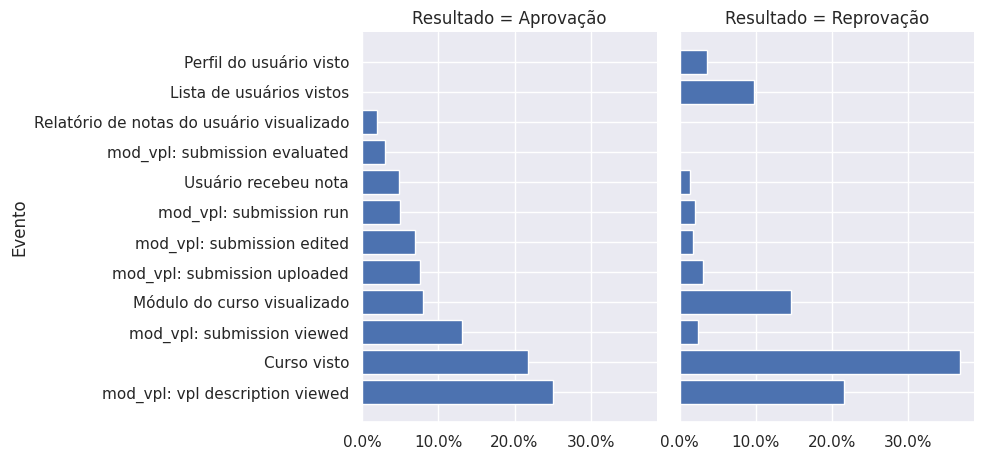

In [7]:
import seaborn as sns
sns.set(rc={"figure.figsize":(18, 7)})

df_final["Resultado"] = np.where(df_final['target_cat'] == 0, "Aprovação", "Reprovação")

tmp = df_final.groupby('Resultado')['Nome do evento'].value_counts(normalize=True).rename_axis(['Resultado', "Evento"]).reset_index(name='counts_norm')
tmp = tmp[ tmp.counts_norm >= 0.01]
tmp["Percentage"] = tmp.counts_norm * 100   
g = sns.FacetGrid(tmp, col="Resultado", height=5)
g = g.map(plt.barh, "Evento", "Percentage")
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,0].set_ylabel('Evento')
g.axes[0,1].set_ylabel('')
g.axes[0,0].xaxis.set_major_formatter(mtick.PercentFormatter())



/home/eduardo/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


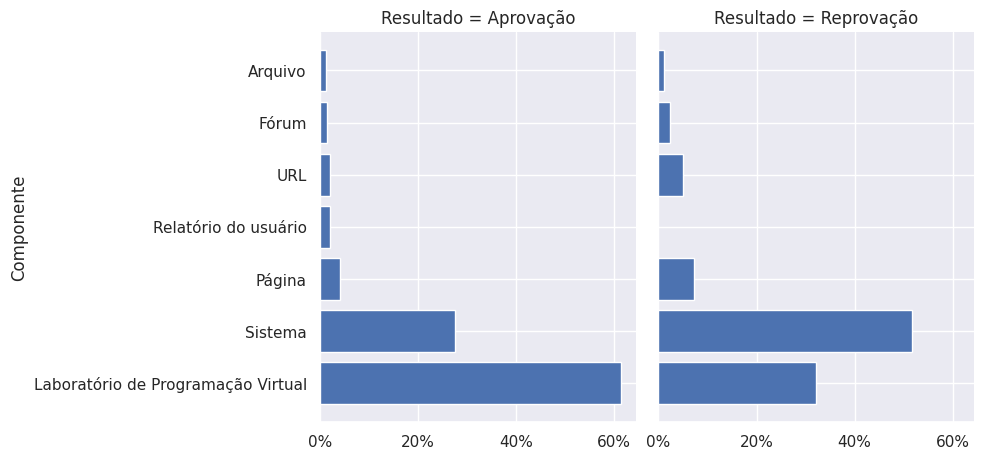

In [8]:
import seaborn as sns
sns.set(rc={"figure.figsize":(18, 7)})

tmp = df_final.groupby('Resultado')['Componente'].value_counts(normalize=True).rename_axis(['Resultado', "Componente"]).reset_index(name='counts_norm')
tmp = tmp[ tmp.counts_norm >= 0.01]
tmp["Percentage"] = tmp.counts_norm * 100   
g = sns.FacetGrid(tmp, col="Resultado", height=5)
g = g.map(plt.barh, "Componente", "Percentage")
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,0].set_ylabel('Componente')
g.axes[0,1].set_ylabel('')
g.axes[0,0].xaxis.set_major_formatter(mtick.PercentFormatter())

/tmp/ipykernel_13805/197016942.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(x="Percentage", y="Evento", hue="Resultado",
/home/eduardo/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


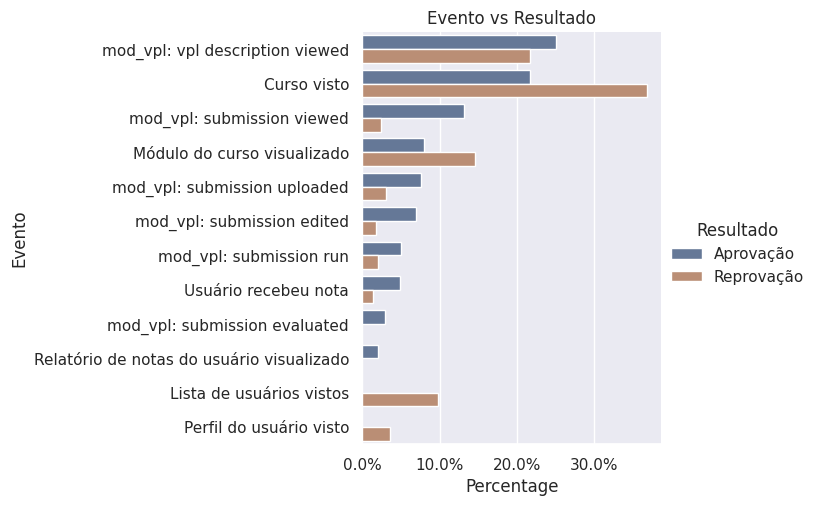

In [9]:
tmp = df_final.groupby('Resultado')['Nome do evento'].value_counts(normalize=True).rename_axis(['Resultado', "Evento"]).reset_index(name='counts_norm')
tmp = tmp[ tmp.counts_norm >= 0.01]
tmp["Percentage"] = tmp.counts_norm * 100  

sns.set(rc={"figure.figsize":(18, 7)})
g = sns.catplot(x="Percentage", y="Evento", hue="Resultado",
                data=tmp, saturation=.5,
                kind="bar", ci=None, aspect=1.5)
g.axes[0,0].set_title("Evento vs Resultado")
g.axes[0,0].xaxis.set_major_formatter(mtick.PercentFormatter())
#g.set_xticklabels(rotation=30) 

/tmp/ipykernel_13805/415409376.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(x="Percentage", y="Componente", hue="Resultado",
/home/eduardo/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


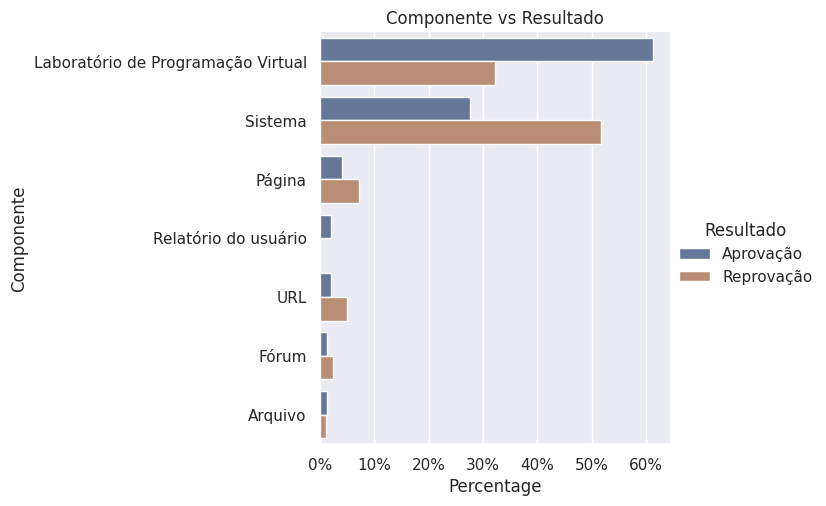

In [10]:
tmp = df_final.groupby('Resultado')['Componente'].value_counts(normalize=True).rename_axis(['Resultado', "Componente"]).reset_index(name='counts_norm')
tmp = tmp[ tmp.counts_norm >= 0.01]
tmp["Percentage"] = tmp.counts_norm * 100  

sns.set(rc={"figure.figsize":(18, 7)})
g = sns.catplot(x="Percentage", y="Componente", hue="Resultado",
                data=tmp, saturation=.5,
                kind="bar", ci=None, aspect=1.5)
g.axes[0,0].set_title("Componente vs Resultado")
g.axes[0,0].xaxis.set_major_formatter(mtick.PercentFormatter())
#g.set_xticklabels(rotation=30) 

/tmp/ipykernel_13805/2752729174.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(x="Percentage", y="Componente", hue="Resultado",
/home/eduardo/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


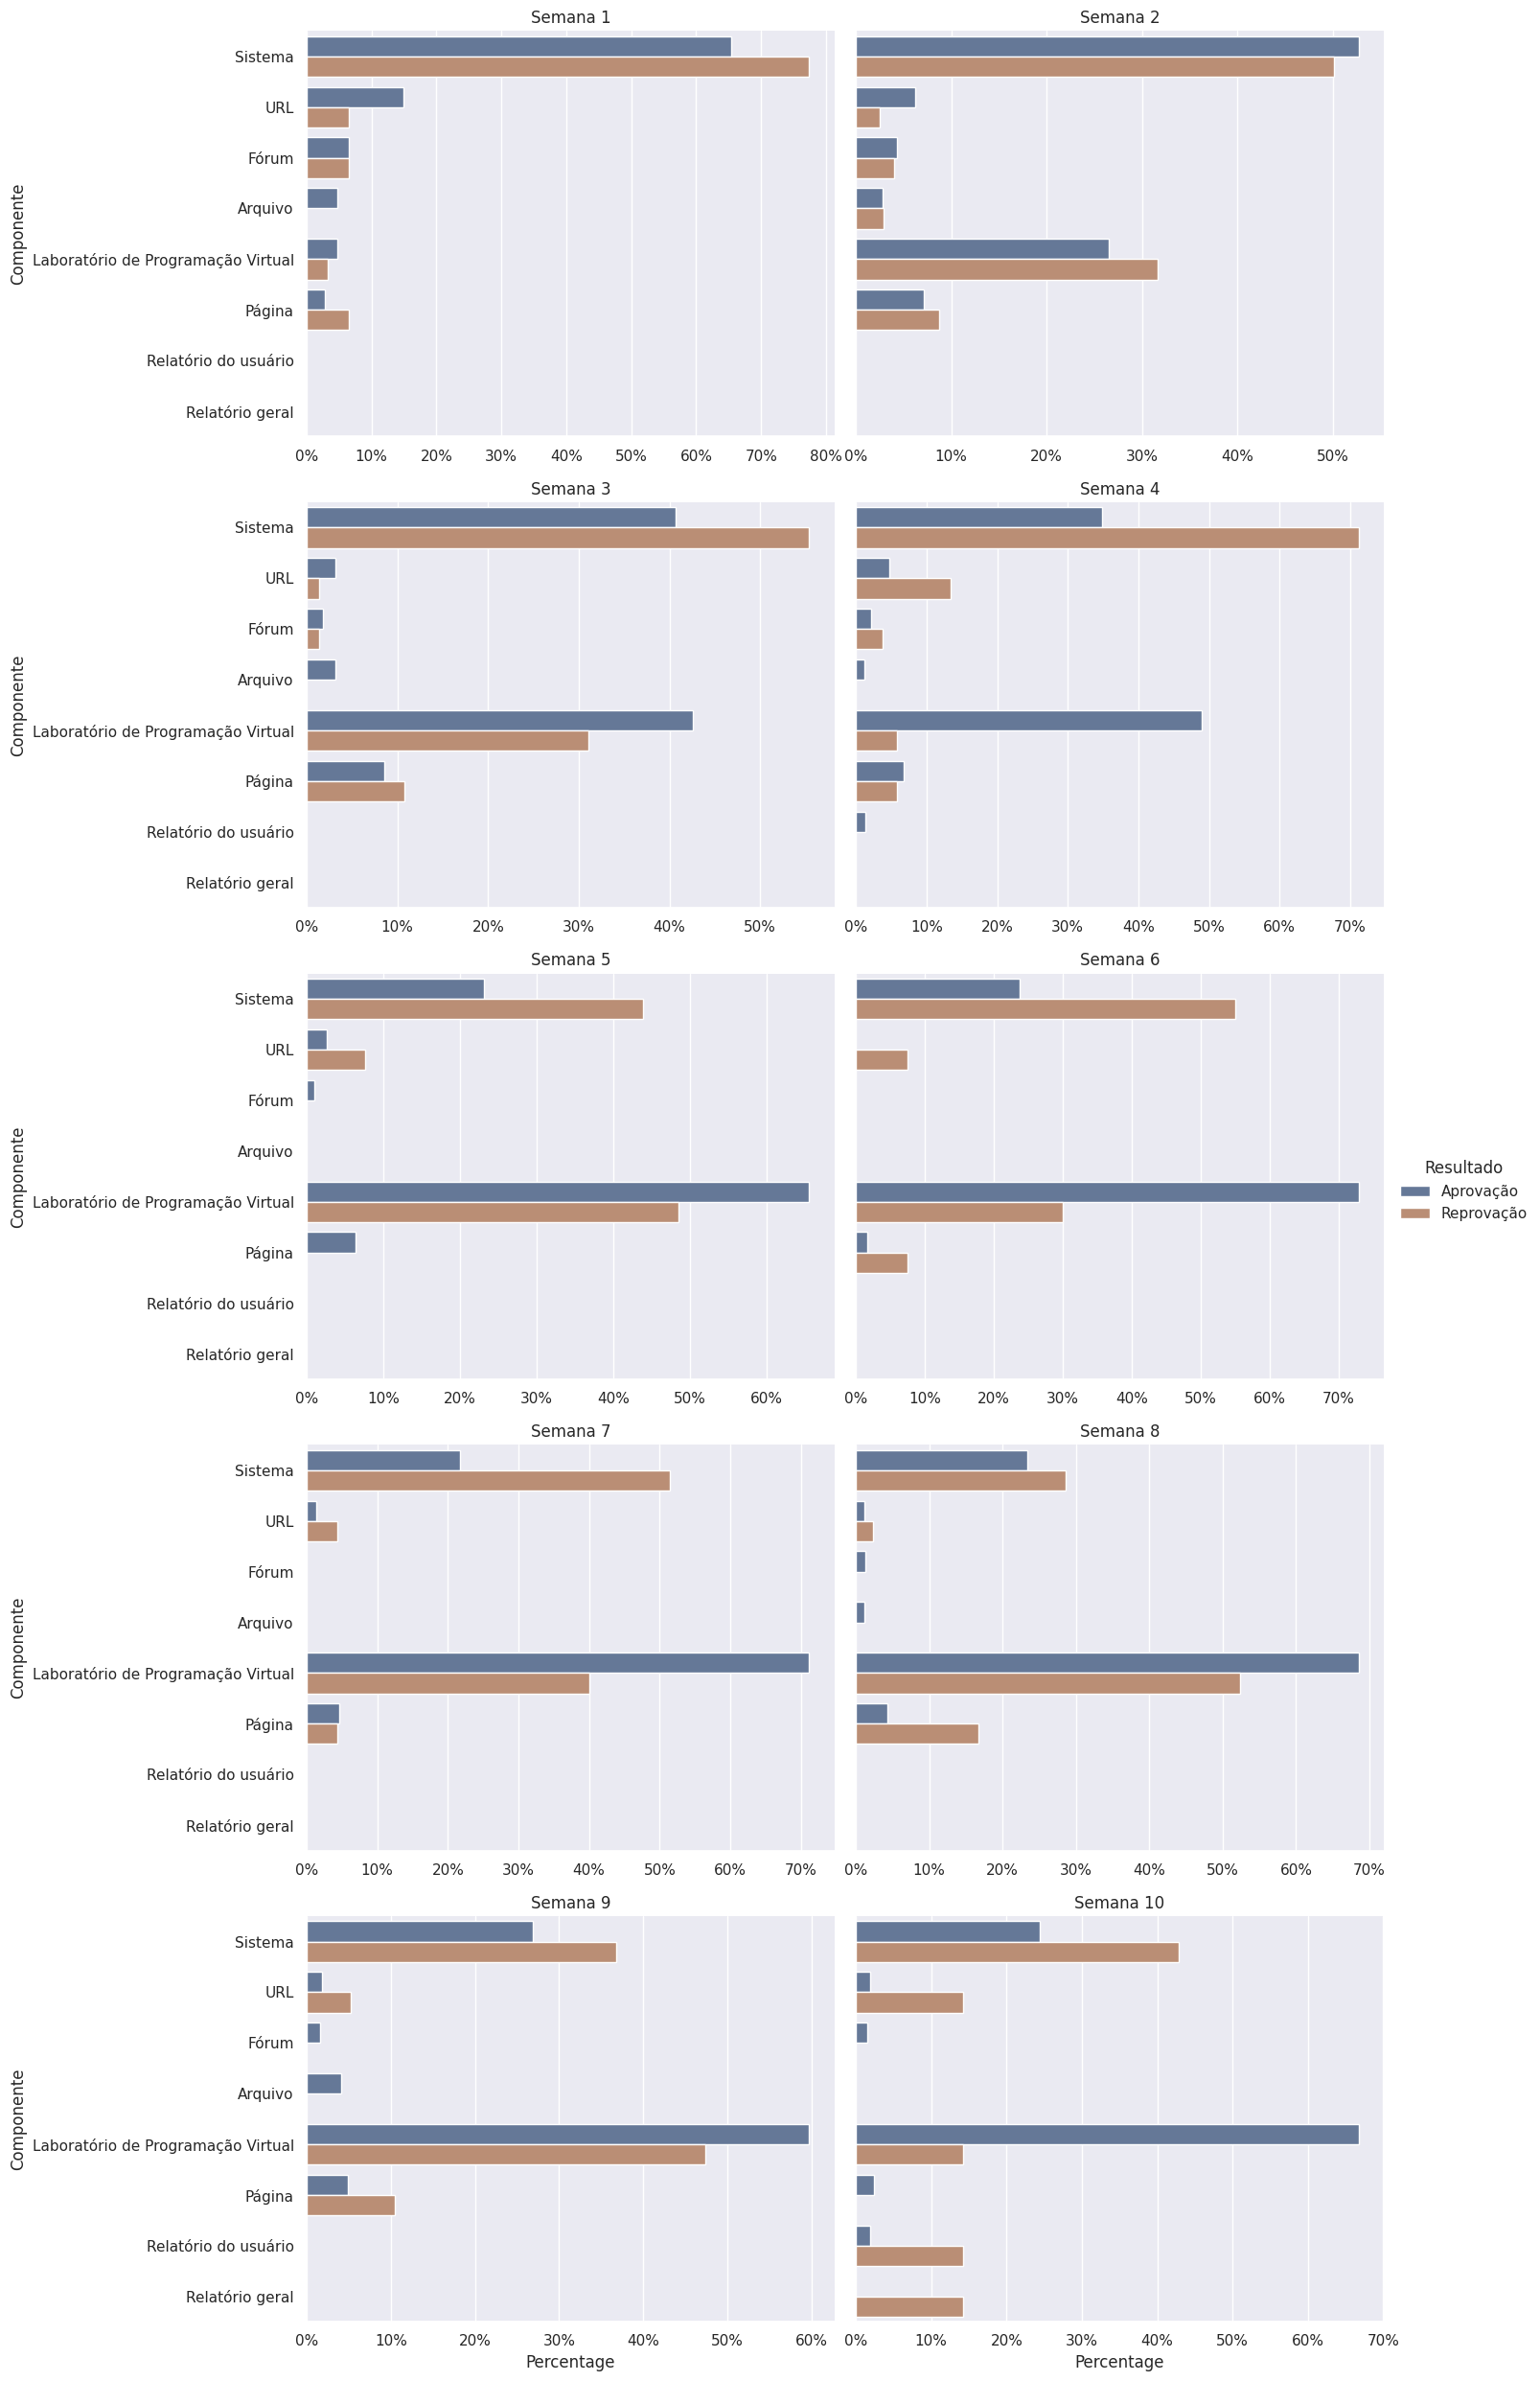

In [11]:
tmp = df_final.groupby(['Resultado','Semana'])["Componente"].value_counts(normalize=True).to_frame()#.rename_axis(['Resultado', 'Semana' "Componente_"])
tmp = tmp.rename_axis(['Resultado', "Semana", "Componente_"]).reset_index()
## changes from 'Componente' to 'proportion'
tmp = tmp.rename(columns={"proportion" : "counts_norm", "Componente_" : "Componente"})
tmp = tmp[ tmp.counts_norm >= 0.01]
tmp["Percentage"] = tmp.counts_norm * 100
tmp = tmp.query("Semana <= 10")
tmp["mod_semana"] = np.where(tmp["Semana"] % 2 != 0, "impar", "par") 
tmp["sum_semana"] = tmp["Semana"] + tmp["Semana"] % 2

sns.set(rc={"figure.figsize":(18, 7)})

g = sns.catplot(x="Percentage", y="Componente", hue="Resultado",
                data=tmp, saturation=.5, row="sum_semana", col="mod_semana",
                kind="bar", ci=None, aspect=1.5, sharex=False)

semana_ = 1
for gg in g.axes:
    gg[0].set_title(f"Semana {semana_}")
    gg[0].xaxis.set_major_formatter(mtick.PercentFormatter())
    semana_ += 1
    gg[1].set_title(f"Semana {semana_}")
    gg[1].xaxis.set_major_formatter(mtick.PercentFormatter())
    semana_ += 1

/tmp/ipykernel_13805/1180447365.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(x="Percentage", y="Evento", hue="Resultado",
/home/eduardo/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


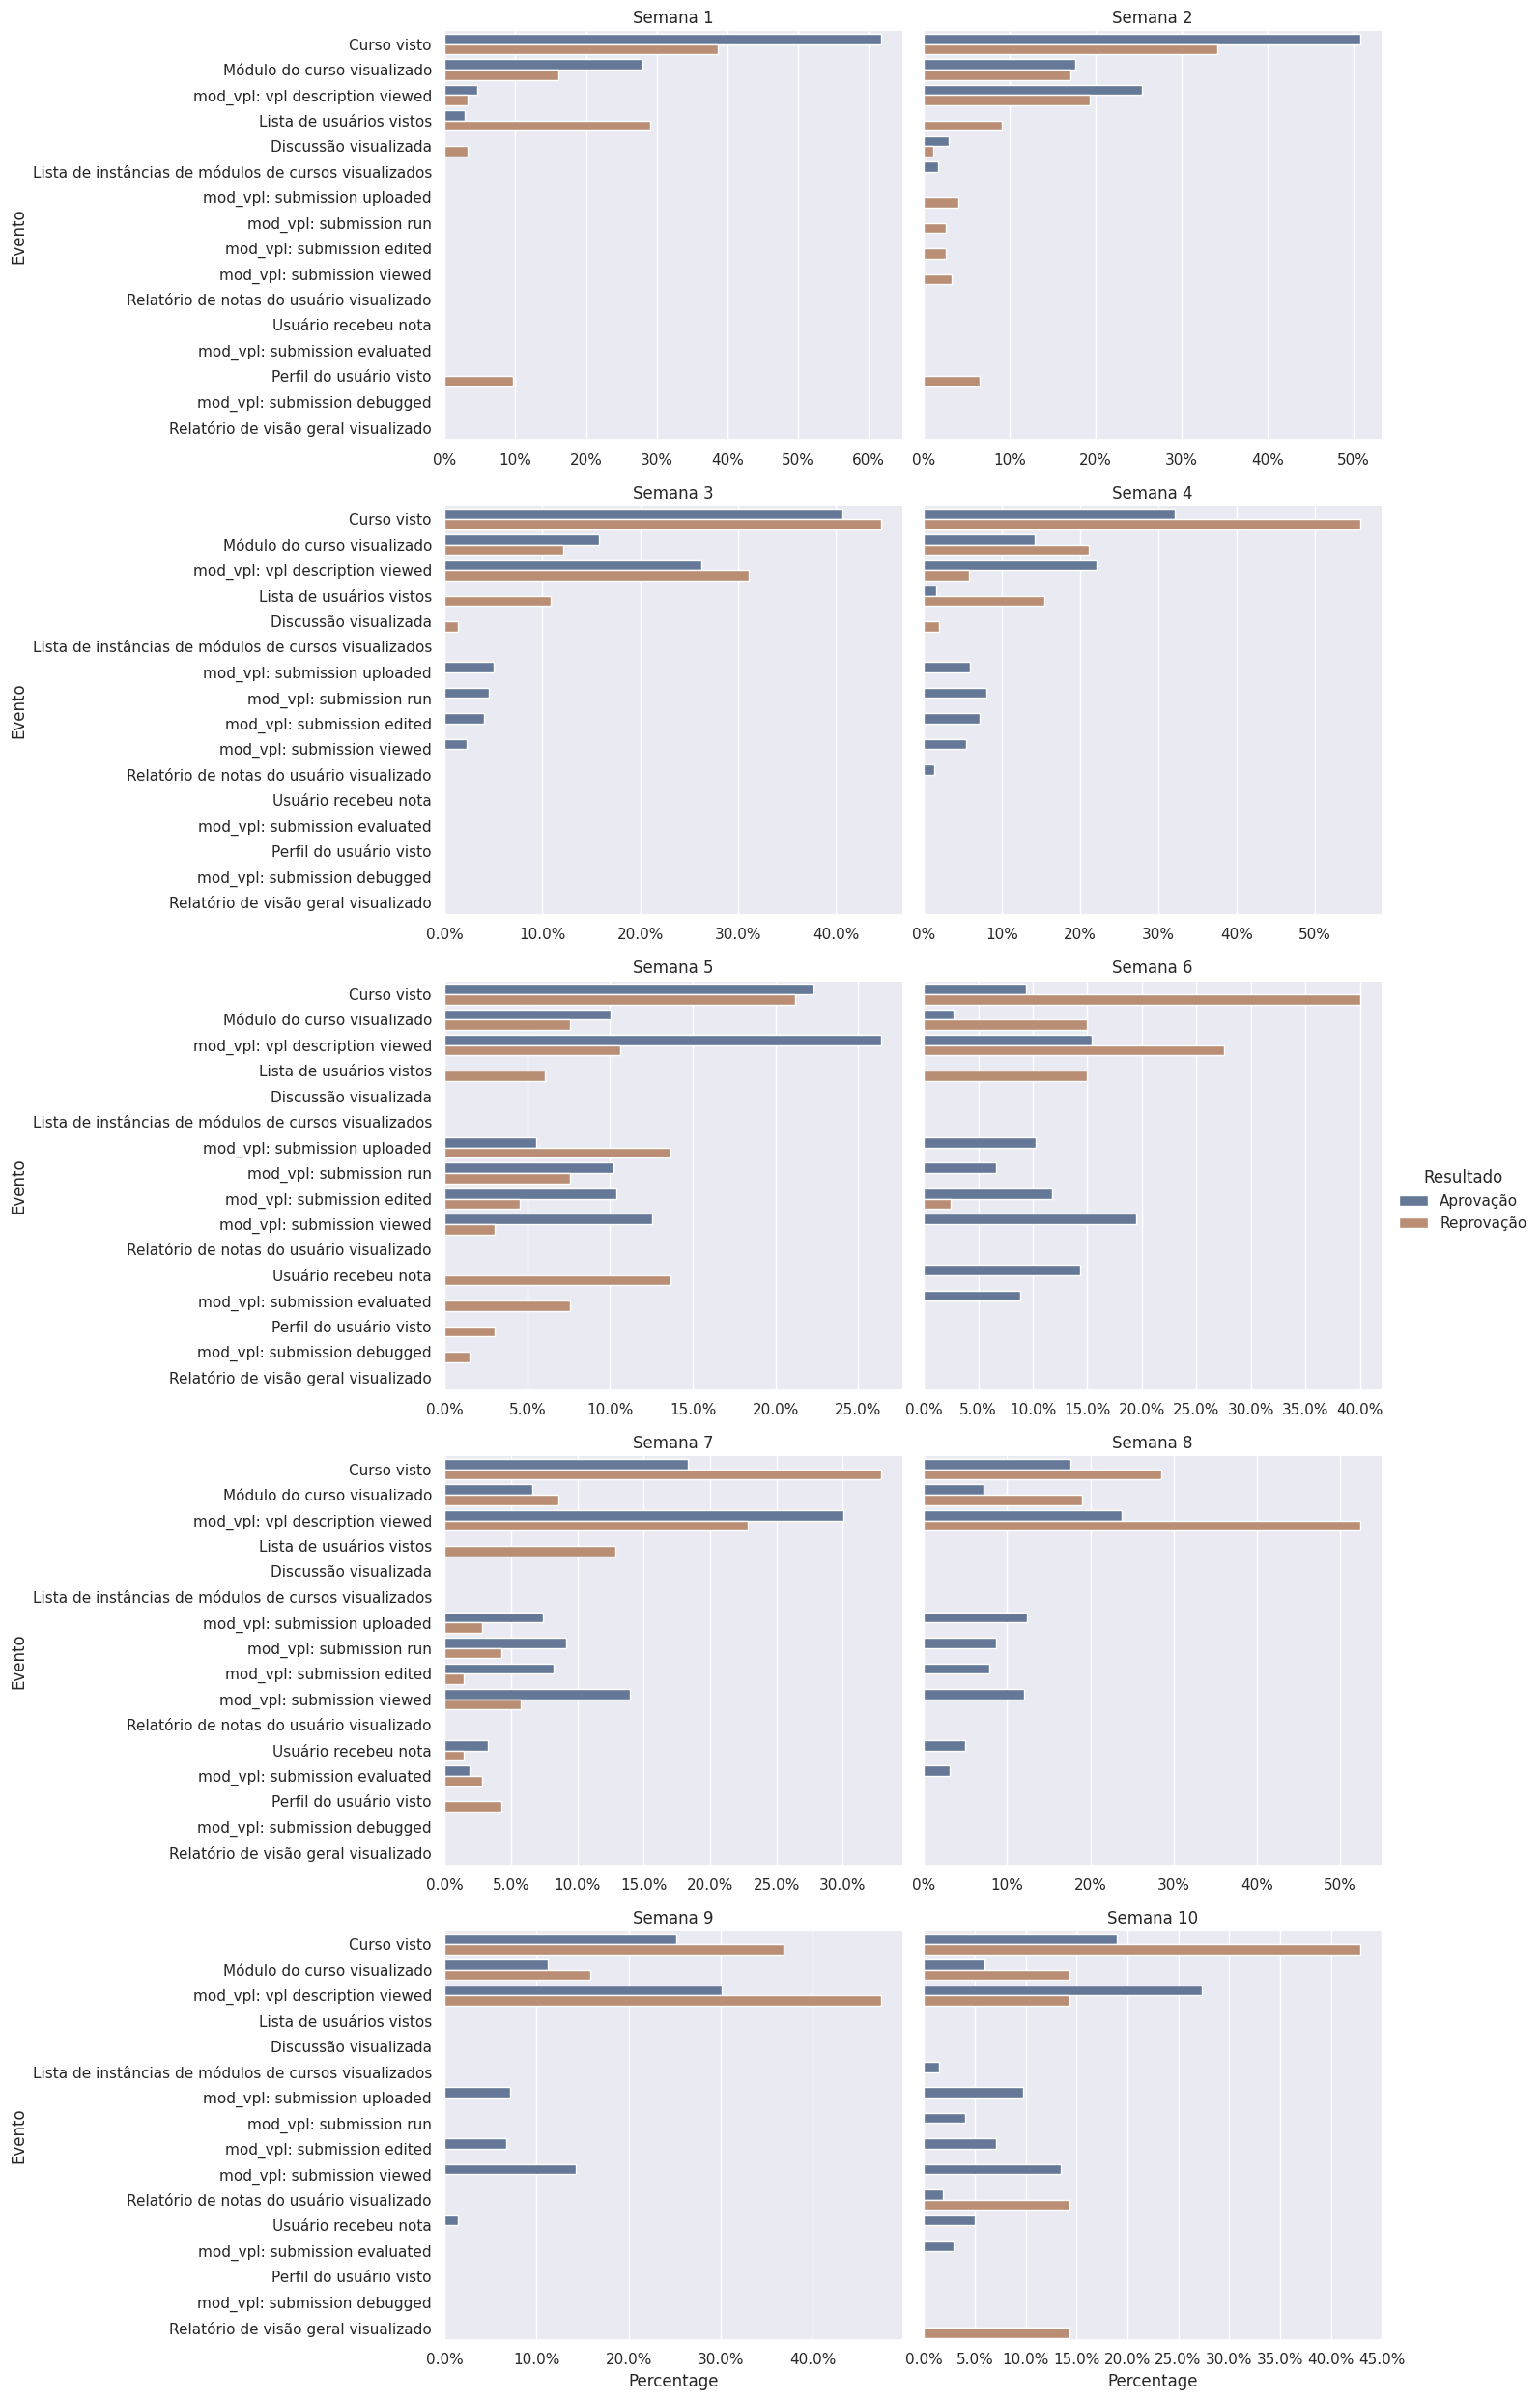

In [12]:
tmp = df_final.groupby(['Resultado','Semana'])["Nome do evento"].value_counts(normalize=True).to_frame()#.rename_axis(['Resultado', 'Semana' "Componente_"])
tmp = tmp.rename_axis(['Resultado', "Semana", "Evento"]).reset_index()
## changes from 'Nome do evento' to 'proportion'
tmp = tmp.rename(columns={"proportion" : "counts_norm"})
tmp = tmp[ tmp.counts_norm >= 0.01]
tmp["Percentage"] = tmp.counts_norm * 100
tmp = tmp.query("Semana <= 10")
tmp["mod_semana"] = np.where(tmp["Semana"] % 2 != 0, "impar", "par") 
tmp["sum_semana"] = tmp["Semana"] + tmp["Semana"] % 2

sns.set(rc={"figure.figsize":(18, 7)})

g = sns.catplot(x="Percentage", y="Evento", hue="Resultado",
                data=tmp, saturation=.5, row="sum_semana", col="mod_semana",
                kind="bar", ci=None, aspect=1.5, sharex=False)

semana_ = 1
for gg in g.axes:
    gg[0].set_title(f"Semana {semana_}")
    gg[0].xaxis.set_major_formatter(mtick.PercentFormatter())
    semana_ += 1
    gg[1].set_title(f"Semana {semana_}")
    gg[1].xaxis.set_major_formatter(mtick.PercentFormatter())
    semana_ += 1